### Session 1: End-to-End ML Hands-on (Titanic)

In this hands-on, you'll build an end-to-end ML workflow on the Titanic dataset using pandas and scikit-learn.

Learning goals:
- Understand the full flow: problem framing → EDA → preprocessing → modeling → evaluation → iteration → export → inference.
- Learn how `Pipeline` and `ColumnTransformer` organize preprocessing and models.
- Practice evaluating models beyond accuracy and prepare a Kaggle-style submission.
- Mini-challenge: feature engineering at the end to improve accuracy.


In [1]:
# Install minimal dependencies (Colab-friendly). 
!pip -q install pandas scikit-learn seaborn matplotlib joblib requests



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\varsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Imports and configuration

Technical notes:
- pandas: data loading and manipulation.
- seaborn/matplotlib: quick EDA visualizations.
- scikit-learn: split, preprocessing, pipelines, models, metrics, hyperparameter search.
- joblib: save/load trained pipelines.


In [2]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)
import joblib


### Data access (dual-mode)

We'll support two approaches:
- Download from public URLs into `/content/data/raw/` (best for Colab and reproducibility).
- Load from local repo path `../data/raw/` (if running locally).

Set `USE_URLS = True` to download; otherwise, the notebook will try local paths.

TODO: Update `TRAIN_URL` and `TEST_URL` to your hosted raw CSV links if using URLs.


### The data

To view the competition data, open the Titanic competition page and click the “Data” tab. You’ll see a list of files:

1) train.csv  
- Contains information for 891 passengers (one row per passenger).  
- The target column is `Survived`:
  - `1` = the passenger survived
  - `0` = the passenger did not survive  
For example, the first row (Mr. Owen Harris Braund) has `Survived = 0` and `Age = 22`.

2) test.csv  
- Contains 418 passengers for which we must predict `Survived`.  
- It does not include a `Survived` column; those labels are hidden for scoring.  
- We will train on `train.csv`, then generate predictions for `test.csv` to create a Kaggle submission.

We’ll use these two files throughout our end-to-end ML workflow: EDA → preprocessing → modeling → evaluation → export → inference → submission.

In [3]:
# Toggle between URL download and local path
USE_URLS = False  # set to False to use local CSVs under ../data/raw/

# TODO: replace with your public raw URLs (e.g., GitHub raw) if needed.
TRAIN_URL = 'https://raw.githubusercontent.com/your-org/your-repo/main/data/raw/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/your-org/your-repo/main/data/raw/test.csv'

DATA_DIR_COLAB = '/content/data/raw'
DATA_DIR_LOCAL = os.path.join('..', 'data', 'raw')
os.makedirs(DATA_DIR_COLAB, exist_ok=True)

def download_if_needed(url: str, dst_dir: str) -> str:
    filename = os.path.basename(url)
    dst_path = os.path.join(dst_dir, filename)
    if not os.path.exists(dst_path):
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        with open(dst_path, 'wb') as f:
            f.write(r.content)
    return dst_path

if USE_URLS:
    train_path = download_if_needed(TRAIN_URL, DATA_DIR_COLAB)
    test_path = download_if_needed(TEST_URL, DATA_DIR_COLAB)
else:
    train_path = os.path.join(DATA_DIR_LOCAL, 'train.csv')
    test_path = os.path.join(DATA_DIR_LOCAL, 'test.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.shape, test_df.shape


((891, 12), (418, 11))

### Problem framing
We are solving a binary classification problem: predict `Survived` (0/1) from passenger features.
Common features include `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, and `Embarked`. The `Name`, `Ticket`, and `Cabin` fields are often noisy.


In [4]:
target_col = 'Survived'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]
X.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Quick EDA
Goals:
- Inspect schema, missingness, and distributions.
- Identify candidate features for modeling and preprocessing needs.

What to look for:
- High missingness columns like `Cabin` (consider dropping) vs moderate ones like `Age` (impute).
- Categorical cardinality for `Ticket`, `Cabin`, `Name` (often excluded in baselines).
- Target leakage risks (none obvious here, but always check temporal or post-outcome fields).

Exercise: Add one more insightful plot (e.g., `Survived` by `Sex` or `Pclass`).


In [5]:
display(train_df.head())
train_df.info()
train_df.isna().mean().sort_values(ascending=False).to_frame('missing_frac')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,missing_frac
Cabin,0.771044
Age,0.198653
Embarked,0.002245
PassengerId,0.000000
Name,0.000000
Pclass,0.000000
Survived,0.000000
Sex,0.000000
Parch,0.000000
SibSp,0.000000


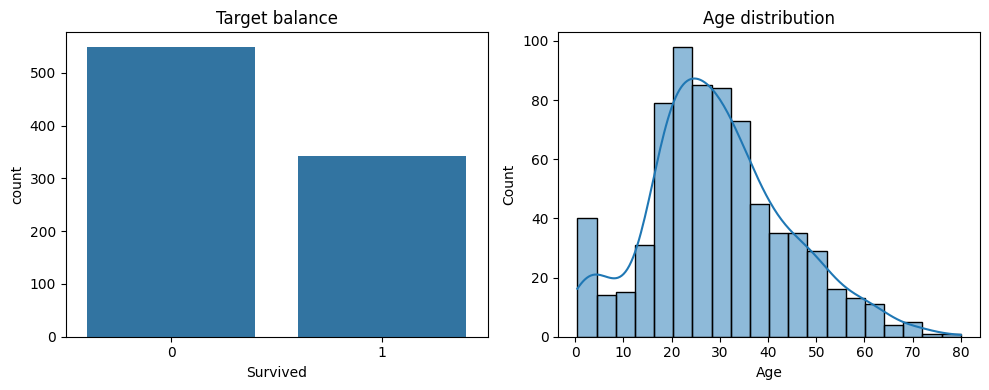

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(data=train_df, x='Survived', ax=axes[0])
axes[0].set_title('Target balance')
sns.histplot(data=train_df, x='Age', kde=True, ax=axes[1])
axes[1].set_title('Age distribution')
plt.tight_layout()
plt.show()


### Train/validation split
We hold out a validation set to estimate generalization. We stratify by the target to preserve class balance.

Key teaching points:
- Split BEFORE any preprocessing to avoid leakage.
- Fit imputers/encoders/scalers ONLY on training folds.
- Keep `X_train`, `X_valid`, `y_train`, `y_valid` unchanged until preprocessing steps.


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_valid.shape


((712, 11), (179, 11))

### Preprocessing (classic, step-by-step without Pipelines)
We will implement preprocessing explicitly so students can see each transformation:
- **Select features**: numeric vs categorical.
- **Fit imputers on train only** and transform train/valid.
- **One-hot encode categoricals** fitted on train only; ignore unknowns at valid/test.
- **Scale numeric features** fitted on train only.

This mirrors what a `Pipeline` does internally, but shows each step so you can inspect intermediate outputs and understand data leakage risks.


In [8]:
# Define feature groups
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# 1) Fit imputers on training data only
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X_train_num = num_imputer.fit_transform(X_train[numeric_features])
X_valid_num = num_imputer.transform(X_valid[numeric_features])

X_train_cat_imputed = cat_imputer.fit_transform(X_train[categorical_features])
X_valid_cat_imputed = cat_imputer.transform(X_valid[categorical_features])

# 2) One-hot encode categoricals: fit on train only
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_oh = onehot.fit_transform(X_train_cat_imputed)
X_valid_cat_oh = onehot.transform(X_valid_cat_imputed)

# 3) Scale numeric features: fit on train only
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_valid_num_scaled = scaler.transform(X_valid_num)

# 4) Concatenate numeric and categorical arrays
X_train_prepared = np.hstack([X_train_num_scaled, X_train_cat_oh])
X_valid_prepared = np.hstack([X_valid_num_scaled, X_valid_cat_oh])

X_train_prepared.shape, X_valid_prepared.shape


((712, 12), (179, 12))

### Baseline model: Logistic Regression on prepared arrays
We train directly on `X_train_prepared` and evaluate on `X_valid_prepared`.
This keeps the modeling step separate from preprocessing for teaching clarity.


In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_prepared, y_train)

y_pred = log_reg.predict(X_valid_prepared)
y_proba = log_reg.predict_proba(X_valid_prepared)[:, 1]

acc = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred)
rec = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
roc = roc_auc_score(y_valid, y_proba)

print('Baseline metrics:')
print(f"- Accuracy : {float(acc):.4f}")
print(f"- Precision: {float(prec):.4f}")
print(f"- Recall   : {float(rec):.4f}")
print(f"- F1       : {float(f1):.4f}")
print(f"- ROC AUC  : {float(roc):.4f}")


(0.8044692737430168,
 0.7931034482758621,
 0.6666666666666666,
 0.7244094488188977,
 np.float64(0.8426877470355731))

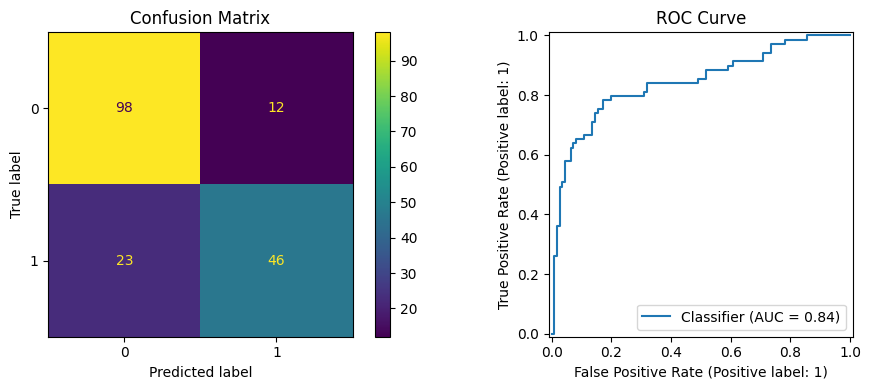

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, ax=ax[0])
ax[0].set_title('Confusion Matrix')
RocCurveDisplay.from_predictions(y_valid, y_proba, ax=ax[1])
ax[1].set_title('ROC Curve')
plt.tight_layout()
plt.show()


### Simple hyperparameter search with GridSearchCV
We keep it simple: use `GridSearchCV` over a few `C` values on the preprocessed training arrays, then evaluate the best model on `X_valid_prepared`.


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = { 'C': [0.1, 1.0, 3.0] }
base_lr = LogisticRegression(max_iter=1000)
search = GridSearchCV(base_lr, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
search.fit(X_train_prepared, y_train)

best_C = search.best_params_['C']
best_acc_cv = search.best_score_
best_C, best_acc_cv


(1.0, np.float64(0.7978036048458584))

In [12]:
# Train best estimator from GridSearchCV on the same prepared arrays
best_model = search.best_estimator_
best_model.fit(X_train_prepared, y_train)

y_pred_best = best_model.predict(X_valid_prepared)
y_proba_best = best_model.predict_proba(X_valid_prepared)[:, 1]
acc_b = accuracy_score(y_valid, y_pred_best)
prec_b = precision_score(y_valid, y_pred_best)
rec_b = recall_score(y_valid, y_pred_best)
f1_b = f1_score(y_valid, y_pred_best)
roc_b = roc_auc_score(y_valid, y_proba_best)

print('Tuned model metrics:')
print(f"- Accuracy : {float(acc_b):.4f}")
print(f"- Precision: {float(prec_b):.4f}")
print(f"- Recall   : {float(rec_b):.4f}")
print(f"- F1       : {float(f1_b):.4f}")
print(f"- ROC AUC  : {float(roc_b):.4f}")


Tuned model metrics:
- Accuracy : 0.8045
- Precision: 0.7931
- Recall   : 0.6667
- F1       : 0.7244
- ROC AUC  : 0.8427


### Error analysis
Inspect where the model fails to guide improvements.

Suggestions to try:
- Add `FamilySize = SibSp + Parch + 1` and retrain.
- Extract `Title` from `Name` and group rare titles.
- Try tree-based models (`RandomForestClassifier`) that may capture non-linearities without scaling.


In [13]:
errors = X_valid.copy()
errors['y_true'] = y_valid.values
errors['y_pred'] = y_pred_best
errors[errors['y_true'] != errors['y_pred']].head(10)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,y_true,y_pred
553,554,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C,1,0
559,560,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36.0,1,0,345572,17.4000,NaN,S,1,0
279,280,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S,1,0
712,713,1,"Taylor, Mr. Elmer Zebley",male,48.0,1,0,19996,52.0000,C126,S,1,0
455,456,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C,1,0
65,66,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C,1,0
489,490,3,"Coutts, Master. Eden Leslie ""Neville""",male,9.0,1,1,C.A. 37671,15.9000,NaN,S,1,0
869,870,3,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,NaN,S,1,0
165,166,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S,1,0
297,298,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S,0,1


### Export the trained components
We will export the fitted preprocessing objects and the `LogisticRegression` model separately with `joblib`:
- `num_imputer.joblib`, `cat_imputer.joblib`
- `onehot.joblib`, `scaler.joblib`
- `log_reg.joblib`

This allows loading them later to preprocess new data in the exact same way.


In [14]:
joblib.dump(num_imputer, 'num_imputer.joblib')
joblib.dump(cat_imputer, 'cat_imputer.joblib')
joblib.dump(onehot, 'onehot.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(best_model, 'log_reg.joblib')
[os.path.getsize(p) for p in ['num_imputer.joblib','cat_imputer.joblib','onehot.joblib','scaler.joblib','log_reg.joblib']]


[855, 996, 1329, 711, 959]

### Inference on test set and Kaggle-style submission
For test-time, we must apply the SAME preprocessing fitted on the full training data:
1) Fit imputers/encoder/scaler on full `X, y` (train only).
2) Transform `test_df` with those fitted objects (never refit on test).
3) Predict with the trained model.
4) Build `submission.csv` with `PassengerId` and `Survived`.

Notes:
- Our `OneHotEncoder(handle_unknown='ignore')` safely handles unseen categories at test-time.
- Always keep the exact same columns/order by reusing the same fitted encoder and scaler.


In [15]:
def fit_full_preprocessing_and_model(X, y, numeric_features, categorical_features, C):
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    scaler = StandardScaler()

    X_num = num_imputer.fit_transform(X[numeric_features])
    X_cat = cat_imputer.fit_transform(X[categorical_features])
    X_cat_oh = onehot.fit_transform(X_cat)
    X_num_s = scaler.fit_transform(X_num)
    X_prep = np.hstack([X_num_s, X_cat_oh])

    model = LogisticRegression(max_iter=1000, C=C)
    model.fit(X_prep, y)
    return num_imputer, cat_imputer, onehot, scaler, model


def transform_with_fitted(num_imputer, cat_imputer, onehot, scaler, df, numeric_features, categorical_features):
    D_num = num_imputer.transform(df[numeric_features])
    D_cat = cat_imputer.transform(df[categorical_features])
    D_cat_oh = onehot.transform(D_cat)
    D_num_s = scaler.transform(D_num)
    return np.hstack([D_num_s, D_cat_oh])


# 1) Fit on full train, 2) Transform test, 3) Predict and save
num_imp_f, cat_imp_f, onehot_f, scaler_f, final_model = fit_full_preprocessing_and_model(
    X, y, numeric_features, categorical_features, C=best_C
)
T_prepared = transform_with_fitted(num_imp_f, cat_imp_f, onehot_f, scaler_f, test_df, numeric_features, categorical_features)

test_pred = final_model.predict(T_prepared)
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_pred
})
submission.to_csv('submission.csv', index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


### Mini-challenge: Add FamilySize and compare
We will create a `FamilySize` feature (`SibSp + Parch + 1`), include it in the numeric features, retrain preprocessing + Logistic Regression, and compare metrics and a second submission file (`submission_family.csv`).


In [16]:
# Add FamilySize
X_train_fs = X_train.copy(); X_valid_fs = X_valid.copy(); X_fs = X.copy(); test_df_fs = test_df.copy()
for df_ in [X_train_fs, X_valid_fs, X_fs, test_df_fs]:
    df_['FamilySize'] = df_['SibSp'] + df_['Parch'] + 1

# Features
numeric_features_fs = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
categorical_features_fs = ['Pclass', 'Sex', 'Embarked']

# Preprocess (fit on train, transform valid)
num_imp = SimpleImputer(strategy='median'); cat_imp = SimpleImputer(strategy='most_frequent')
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False); scaler = StandardScaler()
Xtr_num = num_imp.fit_transform(X_train_fs[numeric_features_fs]); Xva_num = num_imp.transform(X_valid_fs[numeric_features_fs])
Xtr_cat = cat_imp.fit_transform(X_train_fs[categorical_features_fs]); Xva_cat = cat_imp.transform(X_valid_fs[categorical_features_fs])
Xtr = np.hstack([scaler.fit_transform(Xtr_num), onehot.fit_transform(Xtr_cat)])
Xva = np.hstack([scaler.transform(Xva_num), onehot.transform(Xva_cat)])

# Simple GridSearchCV
search_fs = GridSearchCV(LogisticRegression(max_iter=1000), {'C':[0.1,1.0,3.0]}, cv=5, scoring='accuracy', n_jobs=-1)
search_fs.fit(Xtr, y_train)

# Evaluate
best_fs = search_fs.best_estimator_
pred_fs = best_fs.predict(Xva)
proba_fs = best_fs.predict_proba(Xva)[:,1]
acc_fs = accuracy_score(y_valid, pred_fs); prec_fs = precision_score(y_valid, pred_fs)
rec_fs = recall_score(y_valid, pred_fs); f1_fs = f1_score(y_valid, pred_fs); roc_fs = roc_auc_score(y_valid, proba_fs)

print('FamilySize model metrics:')
print(f"- Accuracy : {float(acc_fs):.4f}")
print(f"- Precision: {float(prec_fs):.4f}")
print(f"- Recall   : {float(rec_fs):.4f}")
print(f"- F1       : {float(f1_fs):.4f}")
print(f"- ROC AUC  : {float(roc_fs):.4f}")

# Submission with full train
num_imp_f, cat_imp_f, onehot_f, scaler_f, final_fs = fit_full_preprocessing_and_model(
    X_fs, y, numeric_features_fs, categorical_features_fs, C=search_fs.best_params_['C']
)
T_fs = transform_with_fitted(num_imp_f, cat_imp_f, onehot_f, scaler_f, test_df_fs, numeric_features_fs, categorical_features_fs)
sub_fs = pd.DataFrame({'PassengerId': test_df_fs['PassengerId'], 'Survived': final_fs.predict(T_fs)})
sub_fs.to_csv('submission_family.csv', index=False)
sub_fs.head()


FamilySize model metrics:
- Accuracy : 0.8045
- Precision: 0.7931
- Recall   : 0.6667
- F1       : 0.7244
- ROC AUC  : 0.8433


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
